In [1]:
# Import various Python packages.

import pandas as pd
import numpy as np
import statistics
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

In [2]:
# Import the data set into a Python dataframe, which we will call df.
# Clean the dataframe so we only include the columns CPT, Surgery Time, and Wait Time Target.

df = pd.read_csv("On Time OR - Surgery durations (Richard Hoshino).csv", 
                 names=["A", "B", "C", "CPT", "Time", "F", "G", "H", "I", "WTT", 
                        "K", "L", "M", "N", "O", "P", "Q"])
df = df.drop(["A", "B", "C", "F", "G", "H", "I", "K", "L", "M", "N", "O", "P", "Q"], axis=1)

In [3]:
# Add a new column called LogTime, that takes the natural logarithm of the surgery time.
# Then print out the first five rows of the new dataset.

df["LogTime"] = np.log(df["Time"])
df.head()

,CPT,Time,WTT,LogTime
0,11047,15,4 hours,2.708050
1,11047,60,24 hours,4.094345
2,11047,40,24 hours,3.688879
3,11047,20,24 hours,2.995732
4,11047,60,24 hours,4.094345


In [4]:
# Determine the mean and standard deviation of the entire dataset, for both Time and LogTime.

print("There are", len(df), "total surgeries in the dataset")
print("Time: mean and stdev are", (np.mean(df["Time"]), np.std(df["Time"])))
print("LogTime: mean and stdev are", (np.mean(df["LogTime"]), np.std(df["LogTime"])))


There are 565 total surgeries in the dataset
Time: mean and stdev are (53.32566371681416, 37.714157288181696)
LogTime: mean and stdev are (3.7414152411397064, 0.721057550455386)


Actual 50th percentile: 50.0 minutes
Actual 80th percentile: 75.0 minutes


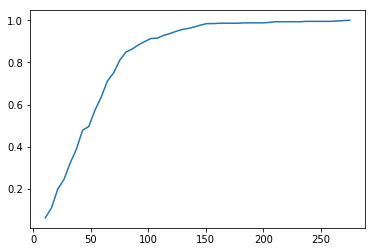

In [5]:
# We draw a Cumulative Distribution Function of the given data, to see the thresholds of surgery
# times for each percentile.  From the results below, we see that 50% of the surgeries last at 
# most 50 minutes, and 80% of the surgeries last at most 75 minutes.

counts, bin_edges = np.histogram(df["Time"], bins=50)
cdf = np.cumsum (counts)
plt.plot (bin_edges[1:], cdf/cdf[-1])

for q in [50, 80]:
    print ("Actual {}th percentile: {} minutes".format (q, np.percentile(df["Time"], q)))

In [6]:
# If the Time variable is normally distributed, we would be able to forecast the expected
# 50th and 80th percentiles, using the Z-values of Z=0 for p=0.5 and Z=0.8416 for p=0.8
# Specifically, 50% of the data is at most mean + 0*stdev, and 80% of the data is at most
# mean + 0.8416*stdev.  We see that both calculations OVER-estimate the actual results of
# 50 minutes and 75 minutes, respectively.

percentile50 = np.mean(df["Time"])
percentile80 = np.mean(df["Time"])+0.8416*np.std(df["Time"])

print("Predicted 50th percentile for Normal distribution:", round(percentile50,2), "minutes")
print("Predicted 80th percentile for Normal distribution:", round(percentile80,2), "minutes")

Predicted 50th percentile for Normal distribution: 53.33 minutes
Predicted 80th percentile for Normal distribution: 85.07 minutes


In [7]:
# If the Time variable is log-normally distributed, then that implies that the LogTime variable
# is normally distributed.  Thus, we re-run the same calculations as above.  We see that this
# prediction is much better, but still off from the actual results of 50 minutes and 75 minutes.

percentile50 = math.exp(np.mean(df["LogTime"]))
percentile80 = math.exp(np.mean(df["LogTime"])+0.8416*np.std(df["LogTime"]))

print("Predicted 50th percentile for LogNormal distribution:", round(percentile50,2), "minutes")
print("Predicted 80th percentile for LogNormal distribution:", round(percentile80,2), "minutes")

Predicted 50th percentile for LogNormal distribution: 42.16 minutes
Predicted 80th percentile for LogNormal distribution: 77.34 minutes


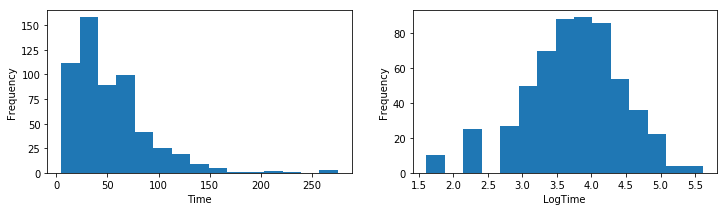

In [8]:
# We now plot the histograms for both Time and LogTime, dividing our data into 15 equal-sized
# bins.  From the picture, we see that the Time data is certainly not normally-distributed,
# while the LogTime data is much closer to a normal distribution.

plt.figure(figsize=(12,3))        
plt.subplot(1,2,1)
plt.hist(df["Time"], bins=15)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.subplot(1,2,2)
plt.hist(df["LogTime"], bins=15)
plt.xlabel("LogTime")
plt.ylabel("Frequency")
plt.show()

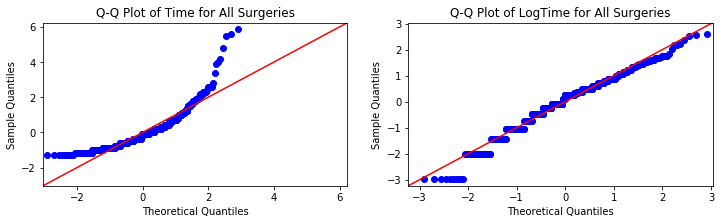

In [9]:
# We use the Quantile-Quantile plot to see how normally distributed our variables are.
# From the picture, we see that Time is nowhere close to being normally distributed, while 
# the LogTime data seems to fit a normal distribution, except at the endpoints.

fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot1 = sm.ProbPlot(df["Time"], fit=True)
plot1.qqplot(line='45', ax=ax[0])
plot2 = sm.ProbPlot(df["LogTime"], fit=True)
plot2.qqplot(line='45', ax=ax[1])
ax[0].set_title('Q-Q Plot of Time for All Surgeries')
ax[1].set_title('Q-Q Plot of LogTime for All Surgeries')
plt.show()

In [10]:
# Because there are so many samples (N=565) in our dataset, any distribution that isn't
# normal will result in a extremely low p-value when using the Shapiro-Wilk test for Normality.
# This is because the "statistical power" of the Shapiro-Wilk normality test is very high
# when we have a large value of N.  This explains why we have a p-value of 0.000 when applying
# the Shapiro-Wilk test to both Time and LogTime.

stat, p = shapiro(df["Time"])
print("Shapiro-Wilk on Time:", 'W = %.3f, p = %.3f' % (stat, p))
if p > 0.05:
    print('Time data looks Gaussian (fail to reject H0)')
else:
    print('Time data does not look Gaussian (reject H0)')
    print('')
stat, p = shapiro(df["LogTime"])
print("Shapiro-Wilk on LogTime:", 'W = %.3f, p = %.3f' % (stat, p))

if p > 0.05:
    print('LogTime data looks Gaussian (fail to reject H0)')
else:
    print('LogTime data does not look Gaussian (reject H0)')

Shapiro-Wilk on Time: W = 0.847, p = 0.000
Time data does not look Gaussian (reject H0)

Shapiro-Wilk on LogTime: W = 0.977, p = 0.000
LogTime data does not look Gaussian (reject H0)


In [11]:
# What we will do then is split our dataset by surgery type, using the CPT code.
# Specifically, we calculate the Shapiro-Wilk test for each CPT code, provided we have
# at least 25 surgeries in the group.  We determine the p-values for the Shapiro-Wilk test,
# for both Time and LogTime data.

for i in df["CPT"].unique():
    count=0
    for j in range(len(df)):
        if df["CPT"][j]==i:
            count+=1
    if count >= 25:
        filter = (df["CPT"] == i)
        newdata = df[filter]
        stat, p1 = shapiro(newdata["Time"])
        stat, p2 = shapiro(newdata["LogTime"])
        if p1<10 and p2>0:
            print("CPT", i, "has", count, "surgeries, with a Time p-value of", 
                  round(p1,3), "and a LogTime p-value of", round(p2,3))

CPT 25515 has 30 surgeries, with a Time p-value of 0.1 and a LogTime p-value of 0.476
CPT 27506 has 38 surgeries, with a Time p-value of 0.0 and a LogTime p-value of 0.288
CPT 27814 has 45 surgeries, with a Time p-value of 0.033 and a LogTime p-value of 0.224
CPT 33217 has 28 surgeries, with a Time p-value of 0.0 and a LogTime p-value of 0.108
CPT 44970 has 26 surgeries, with a Time p-value of 0.02 and a LogTime p-value of 0.435
CPT 47562 has 27 surgeries, with a Time p-value of 0.86 and a LogTime p-value of 0.036
CPT 52353 has 59 surgeries, with a Time p-value of 0.0 and a LogTime p-value of 0.009
CPT 59618 has 58 surgeries, with a Time p-value of 0.1 and a LogTime p-value of 0.05


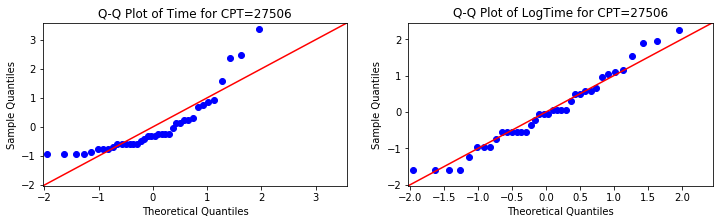

In [12]:
# CPT=27506 (Femural Nail) appears to have a LogNormal distribution, given the low p-value (0.0)
# for Time, and the high p-value (0.288) for LogTime.  Let's check the Quantile-Quantile plots.

filter = (df["CPT"] == 27506)
newdata = df[filter]
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot1 = sm.ProbPlot(newdata["Time"], fit=True)
plot1.qqplot(line='45', ax=ax[0])
plot2 = sm.ProbPlot(newdata["LogTime"], fit=True)
plot2.qqplot(line='45', ax=ax[1])
ax[0].set_title('Q-Q Plot of Time for CPT=27506')
ax[1].set_title('Q-Q Plot of LogTime for CPT=27506')
plt.show()

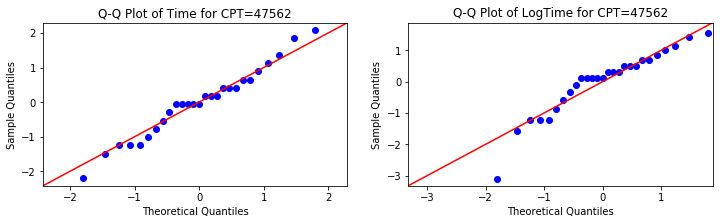

In [13]:
# CPT=47562 (Laparotomy) appears to have a Normal distribution, given the high p-value (0.86)
# for Time, and the low p-value (0.036) for LogTime.  Let's check the Quantile-Quantile plots.

filter = (df["CPT"] == 47562)
newdata = df[filter]
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
plot1 = sm.ProbPlot(newdata["Time"], fit=True)
plot1.qqplot(line='45', ax=ax[0])
plot2 = sm.ProbPlot(newdata["LogTime"], fit=True)
plot2.qqplot(line='45', ax=ax[1])
ax[0].set_title('Q-Q Plot of Time for CPT=47562')
ax[1].set_title('Q-Q Plot of LogTime for CPT=47562')
plt.show()